In [16]:
############################################################
'''
Part 2: RK4 Validation with rocket dynamic + MPC control
'''
# Now we introduce the rocket dynamic here
############################################################

# Required Packages
import numpy as np
import matplotlib.pyplot as plt
from mpccontroller import MPCController
###########################################################

# Parameter Setup
# Integration parameter 
h=1/50  # step size    need at least 1000hz (sec)
t0=0    # initial time (sec)
tf=10   # final time (sec)

time=np.linspace(t0,tf,int((tf-t0)/h))

## States
#1. Hose / 2. Fitting /3. Main Valve/4. Nozzle
# Initial pressure (Pa)
p_s=11e5                  # p_s pressure supply: at the inlet of the hose   
p3_t0=1e5                 # inlet of the nozzle:  assume initial constant air pressure
p3_max_range=11*1e5       # maximum input command for the valve
p3_u_t0=1e5
p3_actual_t0=1e5
pe_t0=1e5
md4n_t0=0.0

# valve delay
Open_t=825e-3       # opening time [s]
Close_t=1700e-3     # closing time[s]

# Initial mass flow rate (kg/s)
state_t0=np.array([p3_u_t0,p3_actual_t0,md4n_t0,pe_t0])
state_t=np.zeros((len(state_t0),len(time)))

###########################################################
# Motion (dynamic system)
x_t0=0.0
v_t0=0.0

x_target=3.0         # height target [m]

motion_t0=np.array([x_t0,v_t0])
motion_t=np.zeros((len(motion_t0),len(time)))


###########################################################
# System & environmental parameters

## Nozzle
Th_d=9e-3                        # throat diameter [m]
Th_exit_d=11e-3                  # exit diameter [m]
A_throat=np.pi*(Th_d/2)**2      #[m^2]
A_e=np.pi*(Th_exit_d/2)**2      #[m^2]
epsilon=A_e/A_throat           #expansion ratio
T_4=273                        #[k]

###########################################################
## mass
m_hop=3.5    # mass of hopper [kg]
m_hose=1.0    # mass of hose   [kg]
k_hose=6     # variable hopper mass [N/m]
F_RR=10      # rolling resistence [N]

## constant
R_gas=8314          # universal gas constant [J/kmol*K]
M=28.013           # nitrogen gas  [kg/kmol]
gamma=1.4          # ratio of specific heats (diatomic gas)
g=9.81             # [m/s^2]
###########################################################
# get mach number directly
Me=1.8486328125000004

In [17]:
## Calculate the basic force 

md4n_term=A_throat/np.sqrt(T_4*R_gas/(M*gamma)) * np.power((gamma+1)/2, -(gamma+1)/(2*(gamma-1)))
ve_term=(2*gamma*R_gas*T_4)/(gamma-1)/M
pe_term=1/np.power(1+((gamma-1)/2*Me**2), gamma/(gamma-1))

ve_suggest_val=float(np.sqrt(ve_term * (1 - np.power(0.1615, (gamma - 1) / gamma))))
print("ve_suggest_value:", ve_suggest_val)

thrust_req= m_hop*(g)+k_hose*x_target
pressure_req=thrust_req/(ve_suggest_val*md4n_term)

print("Basic force need to sustain horizontal at the equilibrium is: ", thrust_req ," [N]")
print("Basic pressure command to reach equilibrium at target", x_target, ":", pressure_req, " [Pa]")

######################################################################
## For MPC parameter (cost function)
Q=np.array([[10.0,0.0],[0.0,10.0]])      
R=np.array([0.01])
Qf=10*Q

N=50                                            # horizon

# initial input
u0=np.array([p3_u_t0]).reshape(-1,1)            # control input p3_u
z0=np.array([md4n_t0,pe_t0]).reshape(-1,1)      # algebraic parameter  initial value: md4n pe       

#target state: xs / initial state x0
xs=np.array([x_target,0.0]).reshape(-1,1)                   
x0=np.array([motion_t0[0],motion_t0[1]]).reshape(-1,1)
mpc=MPCController(motion_t0,u0,z0,Q,R,Qf,xs,20,N)  # Hz 
# Side Note: If the MPC frequency is the same as the simulation frequency can reduce strange oscillation, but need to consider the cost

mpc.setup()

ve_suggest_value: 479.88291219746293
Basic force need to sustain horizontal at the equilibrium is:  52.335  [N]
Basic pressure command to reach equilibrium at target 3.0 : 712636.8665953967  [Pa]


(Function(solver:(x0[254],p[4],lbx[254],ubx[254],lbg[204],ubg[204],lam_x0[254],lam_g0[204])->(x[254],f,g[204],lam_x[254],lam_g[204],lam_p[4]) IpoptInterface),
 Function(f:(states[2],alg_states[2],control)->(ode[2],alg[2]) SXFunction))

In [18]:
## PID parameters for valve control (for the simulation purpose, don't deploy in the real test)
v_kp=2.0   #2.0
v_ki=0.0
v_kd=0.15

v_lasterr=0.0
v_integral=0.0

In [19]:
############################################################################
# RK4 iterative methods

# Butcher Array
RK4matrix=np.array([
      [0,0,0,0],
      [1/4,1/4,0,0],
      [27/40,-189/800,729/800,0],       
      [1,214/891,1/33,650/891],       
      [214/891,1/33,650/891,0],      
   ])


def rk4_ex(f,t,x,h,*args):  #*args allows unknown number of arguments
   k1=f(t+h*RK4matrix[0][0],x+h*RK4matrix[0][1],*args)
   k2=f(t+h*RK4matrix[1][0],x+h*k1*RK4matrix[1][1],*args)
   k3=f(t+h*RK4matrix[2][0],x+h*k2*RK4matrix[2][1],*args)
   k4=f(t+h*RK4matrix[3][0],x+h*k3*RK4matrix[3][1],*args)

   xnext=x+h*(k1*RK4matrix[4][0]+k2*RK4matrix[4][1]+k3*RK4matrix[4][2]+k4*RK4matrix[4][3])
   return xnext

#############################################################################
# Rocket dynamics

def dx(t,motion,dotm,ve,*args):
   xdot=motion[1]
   xdotdot=dotm*ve/m_hop-g-F_RR/m_hop*np.tanh(motion[1])-k_hose*motion[0]/m_hop  
   # the last term (hose) depends on the height, so the higher the target, we need more pressure
   return np.array([xdot,xdotdot])


###########################################################
# Main update function
def stateupdate(t,h,state,motion,v_posi):
   global v_lasterr, v_integral

   p3_u=state[0]
   p3_actual=state[1]
   md4=state[2]
   pe=state[3]
   
   xt=[motion[0],motion[1]]   
   alg_state=np.array([md4,pe])
   v_pos=v_posi
   
   p3_u=mpc.compute_action(x0=np.array(xt).reshape(-1,1),z0=np.array(alg_state).reshape(-1,1),
                           xs=np.array([x_target,0.0]).reshape(-1,1),u0=np.array(p3_u))
   
   #####################################################################

   #####################################################################
   # introduce the actuator delay and PID controller for valve (only use the PD controller actually)
   v_u=(p3_u-1e5)/p3_max_range
   v_u=np.clip(v_u,0,1)          # restrict the valve command to between 0,1 

   v_error=v_u-v_pos
   #PID controller for valve (Note: The overall system is a cascaded PID control loop: pressure command + valve control)
   v_integral +=v_error*h
   v_adjustment = v_kp* v_error+v_kd*(v_error-v_lasterr)/h

   if v_adjustment>0:                 # opening lag
      max_valve_speed=1.0/Open_t
      min_valve_speed=0.0

   elif v_adjustment<0:               # closing lag
      max_valve_speed=0.0
      min_valve_speed=-1.0/Close_t
   else:                         # same input (not closing/opening)
      max_valve_speed=0.0
      min_valve_speed=0.0

   v_lasterr=v_error
   v_speed_actual=np.clip(v_adjustment,min_valve_speed, max_valve_speed)

   v_pos=v_pos+h*v_speed_actual
   v_pos=np.clip(v_pos,0,1)      # restrict the valve position to between 0,1   
   #####################################################################
   # Work 1: replace p3_actual with actual pressure output (delete all the valve stuff since it is just for emmulating the real scenario)
   p3_actual=v_pos*p3_max_range+1e5

   md4n=md4n_term*p3_actual                                                                  # m_choked (at choked condition)

   # Nozzle exit
   pe=p3_actual*pe_term                                                                      # exit pressure
   ve=np.sqrt((2*gamma*R_gas*T_4)/(gamma-1)/M*(1-np.power(pe/p3_actual,(gamma-1)/gamma)))    # exit velocity

   ###########################################################
   # ODE integrator with RK4    

   # Work 2:
   # update the motion--->  (revise it with h_actual and a_actual)
   motion_n=rk4_ex(dx,t,motion,h,md4n,ve)                          # we have to assume the flow to be choked or else v_e will not be constant
   
   # if we haven't increase the height, restrict negative position to zero
   if motion_n[0]<=0:
      motion_n[0]=0.0
      # depend on the real condition (if the rocket hopper is not supported initially, we additional constrained the velocity to be zero)
      # if motoion_n[1]<0:
      #  motion_n[1]=0.0

   #print(" p3_u ",p3_u, " v_pos", v_pos, " p3_actual",p3_actual,)

   return [p3_u,p3_actual,md4n,pe],motion_n,v_pos


In [20]:
# Main iteration loop
state_ti=state_t0
motion_ti=motion_t0
v_pos=0.0     # assume that it is fully closed



for ti in range(len(time)):
    #
    t=time[ti]

    #store the step
    state_t[:,ti]=state_ti
    motion_t[:,ti]=motion_ti

    # calculte the new value (RK4/Algebraic update)
    state_ti,motion_ti,v_pos=stateupdate(t,h,state_ti,motion_ti,v_pos)

    #print(f'Step {t} of {len(time)-1}'.format())



print("final position", motion_ti[0]," final velocity",motion_ti[1])   

final position 2.9931336905365753  final velocity 0.0002033451220335263


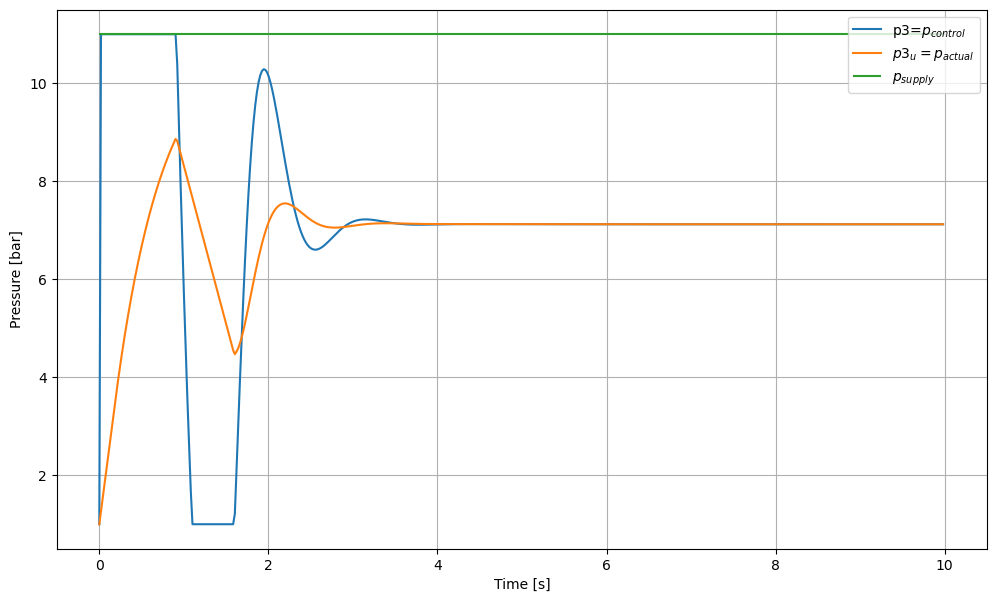

In [21]:
plt.figure(figsize=(12,7))
plt.plot(time[:-1], state_t[0, :-1]/1e5, label='p3=$p_{control}$', color='C0')
plt.plot(time[:-1], state_t[1, :-1]/1e5, label='$p3_u=p_{actual}$', color='C1')
plt.hlines(11.0,xmin=0,xmax=tf,label='$p_{supply}$', color='C2')
plt.xlabel('Time [s]')
plt.ylabel('Pressure [bar]')
# plt.ylim(ymin=9.99999, ymax=10.00001)
plt.grid()
plt.legend()

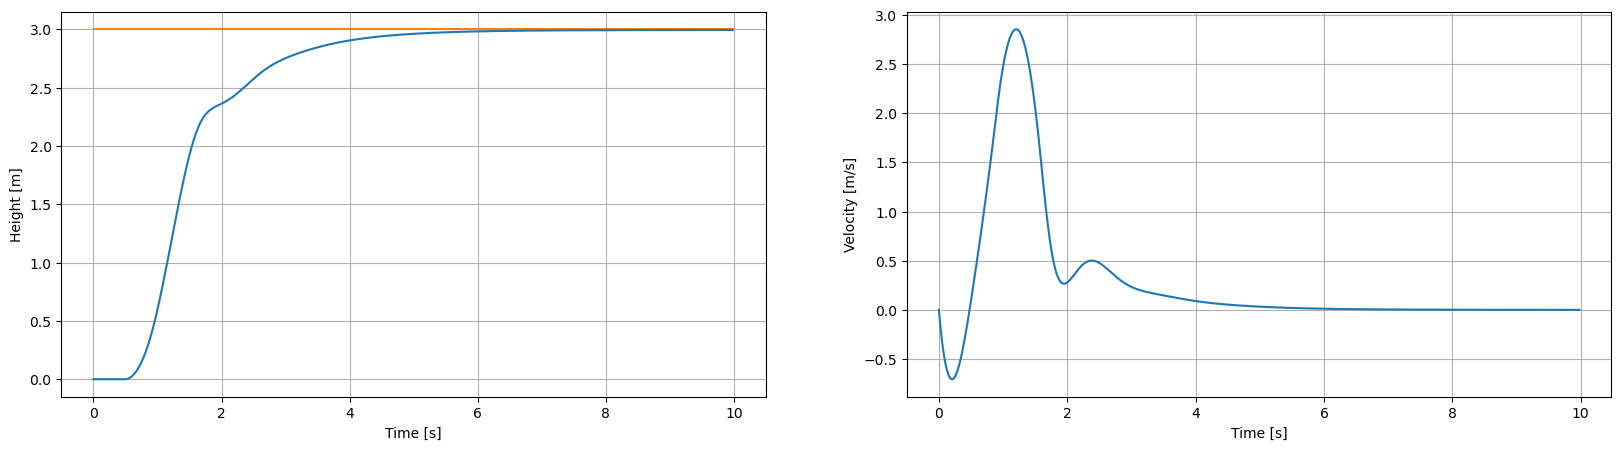

In [22]:
# Visualization

# part 3: motion
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hlines(x_target,xmin=0,xmax=tf,label="target",colors="C1")
plt.plot(time[:-1], motion_t[0, :-1], label='x', color="C0")
plt.xlabel('Time [s]')
plt.ylabel('Height [m]')
plt.grid()


plt.subplot(122)
plt.plot(time[:-1], motion_t[1, :-1], label='v')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.grid()

plt.show()